## Stone -  Estudo de rentabilidade

A planilha em anexo Base_Missão_S.xlsx contém dados fictícios de alguns clientes ao longo de 3 meses. 

Na primeira aba, você vai encontrar um dataset com o volume transacionado, a receita
transacional e a receita de antecipação, assim como o ID dos clientes e seus segmentos de
atuação. 

Na segunda aba, você vai encontrar o ID dos clientes e seu custo de aquisição, o CAC,
contabilizado apenas 1 vez na vida útil do cliente.
O intuito do estudo é que você explore os dados e responda as seguintes perguntas:

1. Qual seria sua sugestão de clusterização da base? Por quê?
2. Estando em um cenário de concorrência acirrada:
 a. Qual estratégia comercial poderíamos implementar para diminuir nossa perda de clientes?
 b. Quais clientes você priorizaria para blindá-los de um eventual ataque da concorrência e por
quê? Não é necessário especificar os IDs dos clientes, apenas explique quais são as
características dos clientes e quantos são.

3. Qual sua sugestão para maximizar o lucro da companhia?
Dica: Caso sinta falta de alguma informação necessária para a conclusão do case utilizando sua
linha de raciocínio, estime-a e explicite o racional.

Monte uma apresentação mostrando sua linha de raciocínio e recomendações. Pedimos
que também nos envie suas análises em excel, python, etc em anexo até as 23:59 do dia
anterior a apresentação.


In [133]:
import pandas as pd
import numpy as np

# Plot histagrans
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [134]:
pd.options.display.float_format = "{:.2f}".format

### Carregar dados

In [135]:
# Load all sheets into a dictionary of DataFrames
file_path = "Base_Missao.xlsx"
sheets_dict = pd.read_excel(file_path, sheet_name=None)

# Extract each sheet as a DataFrame
sheet_names = list(sheets_dict.keys())  # Get sheet names
transactions_df = sheets_dict[sheet_names[0]]  # First sheet
cac_df = sheets_dict[sheet_names[1]]  # Second sheet

# Display sheet names and first rows
print(f"Loaded sheets: {sheet_names}")

Loaded sheets: ['Base Transacional', 'Base CAC']


## Dados de transação + base CAC

Combinar base de dados para melhor entendimento do problemaa.

In [ ]:
cac_df.rename(columns={"CAC (R$)": "CAC"}, inplace=True)

In [138]:
df_full = transactions_df.merge(cac_df, on="ID", how="inner")

#### Avaliar dados faltantes

In [139]:
df_full.isnull().sum()

ID                                        0
Segmento                                  0
Mês                                       0
Volume transacional (R$)                  0
Receita Transacional (R$)                 0
Receita Antecipação de recebíveis (R$)    0
CAC                                       0
dtype: int64

#### Renomear colunas para melhor entendimento

In [140]:
df_full.rename(
    columns={
        "Volume transacional (R$)": "volume_transacional",
        "Receita Transacional (R$)": "receita_transacional",
        "Receita Antecipação de recebíveis (R$)": "receita_recebiveis",
    },
    inplace=True,
)

#### Criar features que retratem a rentablidade de serviços prestada pelo banco

Métricas calculadas são 'proxy' das taxas de serviços prestados pela Stone:

* taxa Stone $\rightarrow$ Razão entre a receita e o volume transacionais.
* taxa recebíveis $\rightarrow$ Razão entre a receita de recebíveis e o volume transacional.
* taxa spread $\rightarrow$ Diferença entre ambas as taxas

In [141]:
df_full["taxa_stone"] = (
    df_full["receita_transacional"] / df_full["volume_transacional"] * 100
)

df_full["taxa_recebiveis"] = (
    df_full["receita_recebiveis"] / df_full["volume_transacional"] * 100
)
df_full.loc[df_full["taxa_recebiveis"] == 0, "taxa_recebiveis"] = np.nan

df_full["taxa_spread"] = df_full["taxa_recebiveis"] - df_full["taxa_stone"]
df_full

,ID,Segmento,Mês,volume_transacional,receita_transacional,receita_recebiveis,CAC,taxa_stone,taxa_recebiveis,taxa_spread
0,1,Restaurante,1,802760.00,3652.56,0.00,9204.45,0.46,NaN,NaN
1,1,Restaurante,2,184634.80,840.09,0.00,9204.45,0.46,NaN,NaN
2,2,Restaurante,1,149635.00,1077.37,0.00,3296.76,0.72,NaN,NaN
3,3,Restaurante,1,32389.00,251.01,699.60,1475.99,0.78,2.16,1.38
4,3,Restaurante,2,33684.56,261.06,727.59,1475.99,0.78,2.16,1.38
...,...,...,...,...,...,...,...,...,...,...
23393,11506,Material de Construção,3,773541.00,5124.71,0.00,18141.47,0.66,NaN,NaN
23394,11507,Material de Construção,3,17613.00,313.73,0.00,847.08,1.78,NaN,NaN
23395,11508,Material de Construção,3,56880.00,668.34,0.00,2045.12,1.18,NaN,NaN
23396,11509,Material de Construção,3,25162.00,267.35,735.99,1401.68,1.06,2.92,1.86


### Entendendo transações

In [142]:
df_full.describe()

,ID,Mês,volume_transacional,receita_transacional,receita_recebiveis,CAC,taxa_stone,taxa_recebiveis,taxa_spread
count,23398.00,23398.00,23398.00,23398.00,23398.00,23398.00,23398.00,10796.00,10796.00
mean,5358.86,2.01,100869.42,634.00,555.54,2679.55,0.93,2.30,1.52
std,3506.25,0.82,167588.90,648.98,1127.14,2522.16,0.37,0.43,0.27
min,1.00,1.00,2040.20,23.81,0.00,320.78,0.16,0.93,0.71
25%,2124.25,1.00,29073.07,280.88,0.00,1390.43,0.68,2.14,1.37
50%,5248.00,2.00,46761.10,448.90,0.00,2012.22,0.89,2.34,1.53
75%,8249.75,3.00,89035.43,727.95,843.69,3015.98,1.16,2.58,1.69
max,11510.00,3.00,1315062.04,7726.64,20974.03,37571.92,2.06,3.28,2.28


In [143]:
stats_segment = (
    df_full.groupby(["Segmento"], as_index=True, sort=True)
    .agg(
        {
            "ID": ["nunique"],
            "CAC": ["mean"],
            "receita_transacional": ["mean", "sum"],
            "taxa_stone": ["mean", "min", "max"],
            "taxa_recebiveis": ["mean", "sum"],
            "taxa_spread": ["mean"],
        }
    )
    .round(2)
)

# Count unique clients where taxa_recebiveis is NOT null
stats_segment["#_clients_recebiveis"] = (
    df_full.loc[df_full["taxa_recebiveis"].notna()].groupby("Segmento")["ID"].nunique()
)

# Flatten multi-level column names
stats_segment.columns = ["_".join(col).strip() for col in stats_segment.columns.values]

# Rename columns for clarity
stats_segment.rename(
    columns={
        "taxa_stone_mean": "taxa_stone_avg",
        "taxa_stone_min": "taxa_stone_min",
        "taxa_stone_max": "taxa_stone_max",
        "taxa_recebiveis_mean": "taxa_recebiveis_avg",
        "taxa_recebiveis_sum": "total_recebiveis",
        "ID_nunique": "#_clients",
        "#_clients_recebiveis_": "#_clients_recebiveis",
    },
    inplace=True,
)

# Display result
stats_segment["share_clients_recebiveis"] = (
    stats_segment["#_clients_recebiveis"] / stats_segment["#_clients"] * 100
)
stats_segment

,#_clients,CAC_mean,receita_transacional_mean,receita_transacional_sum,taxa_stone_avg,taxa_stone_min,taxa_stone_max,taxa_recebiveis_avg,total_recebiveis,taxa_spread_mean,#_clients_recebiveis,share_clients_recebiveis
Segmento,,,,,,,,,,,,
Material de Construção,1510,2929.01,693.38,2709053.70,1.23,0.34,2.06,2.76,4378.40,1.81,589,39.01
Posto de Gasolina,1152,3911.33,1057.46,3200945.47,0.45,0.16,1.06,1.25,764.98,0.87,223,19.36
Restaurante,3649,2203.74,493.94,4540833.61,0.92,0.26,1.65,2.26,11981.47,1.47,2044,56.02
Supermercado,712,2132.57,536.95,977781.12,0.74,0.22,1.32,1.72,1104.28,1.14,250,35.11
Vestuário,2072,2801.91,624.91,3405781.98,1.06,0.29,1.90,2.50,6652.50,1.66,984,47.49


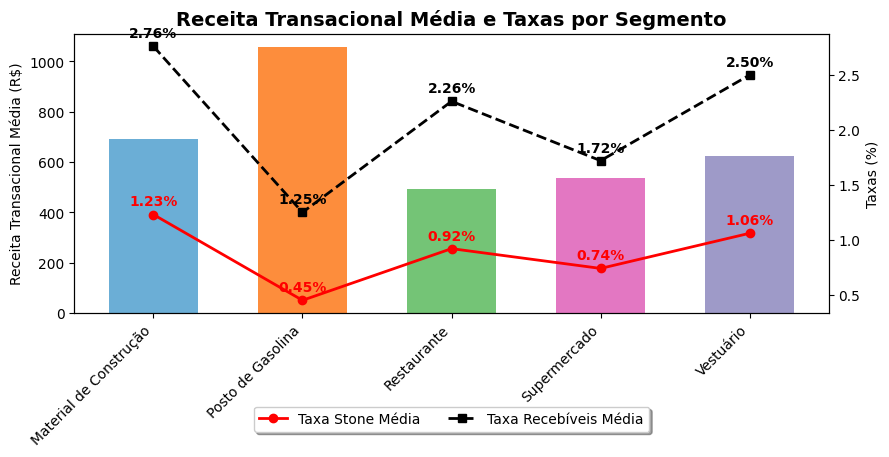

In [159]:
# Set figure size
fig, ax1 = plt.subplots(figsize=(9, 5))

# X positions for bars
x_pos = np.arange(len(stats_segment["Segmento"]))  # Numeric x positions

# Define bar colors
bar_colors = ["#6baed6", "#fd8d3c", "#74c476", "#e377c2", "#9e9ac8"]

# Bar Plot (Primary Y-axis) using Matplotlib
ax1.bar(
    x_pos,
    stats_segment["receita_transacional_mean"],
    color=bar_colors,
    label="Receita Transacional Média",
    width=0.6,  # Adjust bar width
)

# Customize primary Y-axis
ax1.set_ylabel("Receita Transacional Média (R$)", color="black")
ax1.set_xlabel("")
ax1.set_xticks(x_pos)  # Set numeric x positions
ax1.set_xticklabels(stats_segment["Segmento"], rotation=45, ha="right")  # Rotate labels
ax1.tick_params(axis="y", labelcolor="black")

# Create a secondary Y-axis for the line plots
ax2 = ax1.twinx()

# Line Plot 1: Taxa Stone Média
ax2.plot(
    x_pos,
    stats_segment["taxa_stone_avg"],
    marker="o",
    color="red",
    linestyle="-",
    linewidth=2,
    label="Taxa Stone Média",
)

# Line Plot 2: Taxa Recebíveis Média
ax2.plot(
    x_pos,
    stats_segment["taxa_recebiveis_avg"],
    marker="s",
    color="black",
    linestyle="--",
    linewidth=2,
    label="Taxa Recebíveis Média",
)

# Customize secondary Y-axis
ax2.set_ylabel("Taxas (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Annotate all data points for both line plots
for feature, color in zip(["taxa_stone_avg", "taxa_recebiveis_avg"], ["red", "black"]):
    for i, y in enumerate(stats_segment[feature]):
        ax2.text(
            x_pos[i],
            y + 0.08,  # Adjust text position slightly higher
            f"{y:.2f}%",
            color=color,
            fontsize=10,
            ha="center",
            fontweight="bold",
        )

# Manually create a legend for line plots
ax2.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.45),  # Moves legend **below** the chart
    fancybox=True,
    shadow=True,
    ncol=2,  # Arrange legends in two columns
)

# Set Title
plt.title(
    "Receita Transacional Média e Taxas por Segmento", fontsize=14, fontweight="bold"
)

# Adjust layout for better spacing
plt.tight_layout()

# Show Plot
plt.show()

### Entendendo CAC

In [165]:
### Estatisticas descritivas

cac_df.describe()

,ID,CAC
count,9095.00,9095.00
mean,5396.13,2628.57
std,3484.13,2497.65
min,1.00,320.78
25%,2274.50,1357.00
50%,5187.00,1970.59
75%,8308.50,2951.19
max,11510.00,37571.92


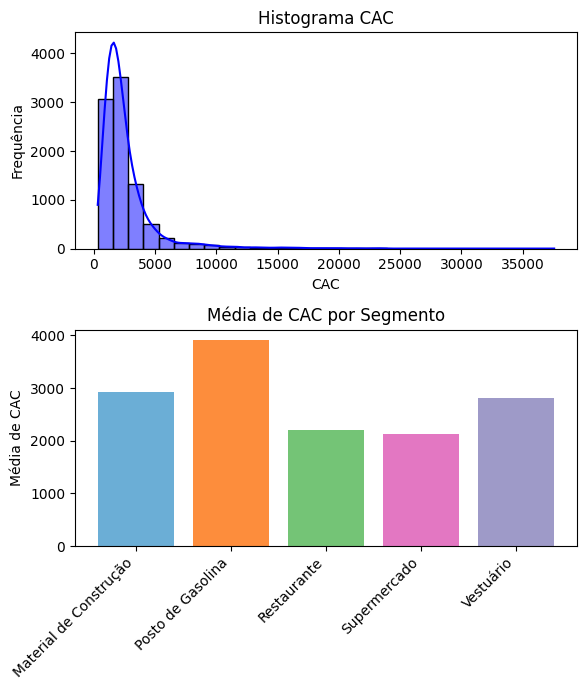

In [119]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7))  # Create side-by-side plots

# Histogram using Seaborn
sns.histplot(cac_df["CAC"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Histograma CAC")
axes[0].set_xlabel("CAC")
axes[0].set_ylabel("Frequência")

# Barplot using Matplotlib
segmentos = stats_segment["Segmento"].unique()  # Get unique segment names
x_pos = np.arange(len(segmentos))  # Generate positions for bars

axes[1].bar(
    x_pos,
    stats_segment["CAC_mean"],
    color=["#6baed6", "#fd8d3c", "#74c476", "#e377c2", "#9e9ac8"],
)

axes[1].set_title("Média de CAC por Segmento")
axes[1].set_xlabel("")
axes[1].set_ylabel("Média de CAC")

# Set x-ticks correctly
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(segmentos, rotation=45, ha="right")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Avaliar payback CAC dos clientes

In [120]:
# Fazer soma acumulada de receitas
df_full["cum_revenue_3m"] = (
    df_full.groupby("ID")["receita_transacional"]
    .rolling(3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# Identificar se pagou ou nao
df_full["pay_cac"] = np.where(df_full["cum_revenue_3m"] >= df_full["CAC"], 1, 0)

In [121]:
# Calcular algumas métricas
unique_ids = df_full.loc[df_full["pay_cac"] == 1, "ID"].unique()
total_clientes_cac = len(unique_ids)

percentage_cac = (total_clientes_cac / df_full["ID"].nunique()) * 100

print("Total de clientes que cobriram CAC:", total_clientes_cac)
print(f"% de clientes que cobriram CAC: {percentage_cac:.2f}%")

Total de clientes que cobriram CAC: 1021
% de clientes que cobriram CAC: 11.23%


In [122]:
### proporção de clientes por segmento payback CAC
total_ids_per_segmento = df_full.groupby("Segmento")["ID"].nunique()

# Contar valores pay_cac ==1
ids_with_pay_cac = df_full[df_full["pay_cac"] == 1].groupby("Segmento")["ID"].nunique()

# calcular proporção
proportion_pay_cac = (ids_with_pay_cac / total_ids_per_segmento * 100).round(2)

# gerear D|ataFrame
df_proportion = proportion_pay_cac.reset_index().rename(
    columns={"ID": "percentage_pay_cac"}
)
df_proportion

,Segmento,percentage_pay_cac
0,Material de Construção,12.65
1,Posto de Gasolina,16.67
2,Restaurante,8.11
3,Supermercado,14.89
4,Vestuário,11.39


### Observações iniciais:
* Segmento Popstos de Gasolina é o mais beneficiado em termos de taxa pela Stone;
  * Menor taxa sobre volume transacional (taxa_spread) e menor spread.
  * Menos de 20% dos clientes utiliza outros serviços da Stone;
  * Maior prêmio para entrada (CAC alto):
    * 85% mais caro que Supermercado e 80% em relação à Restaurante.
* Segmento de Restaurante é o que mais utiliza de antecipação de recebíveis. 
* Segmento de Material de Cosntrução é o que pag as maiores taxas:
  * Barreira a contratação de novos produtos por esse segmento. 
  * Dado o contexto de **avaliação de risco**: Essas taxas não seriam muito punitivas/limitador a estes dois segmentos? 

Algumas possibilidade de aumento de receita/lucro:
1. Aumentar/Diminuir a receita do serviço prestado
2. Aumnetar a taxa de serviços financeiros $\rightarrow$ Aumentar o spread
3. Reduzir CAC $\rightarrow$ Reduzir payback

## Questões:
### Questão 1: Qual seria sua sugestão de clusterização da base? Por quê?

Sugestão: clusterização por taxa_stone.

Por que?

1. Segue uma distribuição mais espalhada: 
   * Diferente das outras variáveis (que são altamente assimétricas), a taxa_stone possui um intervalo mais amplo e parece estar mais próxima de uma distribuição normal.
2. Picos visíveis de densidade: 
    * Sgere agrupamentos naturais nos dados, o que é ideal para algoritmos de clusterização como K-Means ou DBSCAN.
3. Não apresenta extremos tão intensos quanto volume_transacional ou receita_transacional: Essas duas variáveis possuem outliers extremos que podem distorcer os resultados da clusterização.

Estatísticas descritivas


,ID,Mês,volume_transacional,receita_transacional,receita_recebiveis,CAC,taxa_stone,taxa_recebiveis,taxa_spread,cum_revenue_3m,pay_cac
count,23398.00,23398.00,23398.00,23398.00,23398.00,23398.00,23398.00,10796.00,10796.00,23398.00,23398.00
mean,5358.86,2.01,100869.42,634.00,555.54,2679.55,0.93,2.30,1.52,1208.78,0.04
std,3506.25,0.82,167588.90,648.98,1127.14,2522.16,0.37,0.43,0.27,1427.07,0.20
min,1.00,1.00,2040.20,23.81,0.00,320.78,0.16,0.93,0.71,56.28,0.00
25%,2124.25,1.00,29073.07,280.88,0.00,1390.43,0.68,2.14,1.37,442.67,0.00
50%,5248.00,2.00,46761.10,448.90,0.00,2012.22,0.89,2.34,1.53,784.75,0.00
75%,8249.75,3.00,89035.43,727.95,843.69,3015.98,1.16,2.58,1.69,1415.94,0.00
max,11510.00,3.00,1315062.04,7726.64,20974.03,37571.92,2.06,3.28,2.28,20152.52,1.00



Histogramas truncados


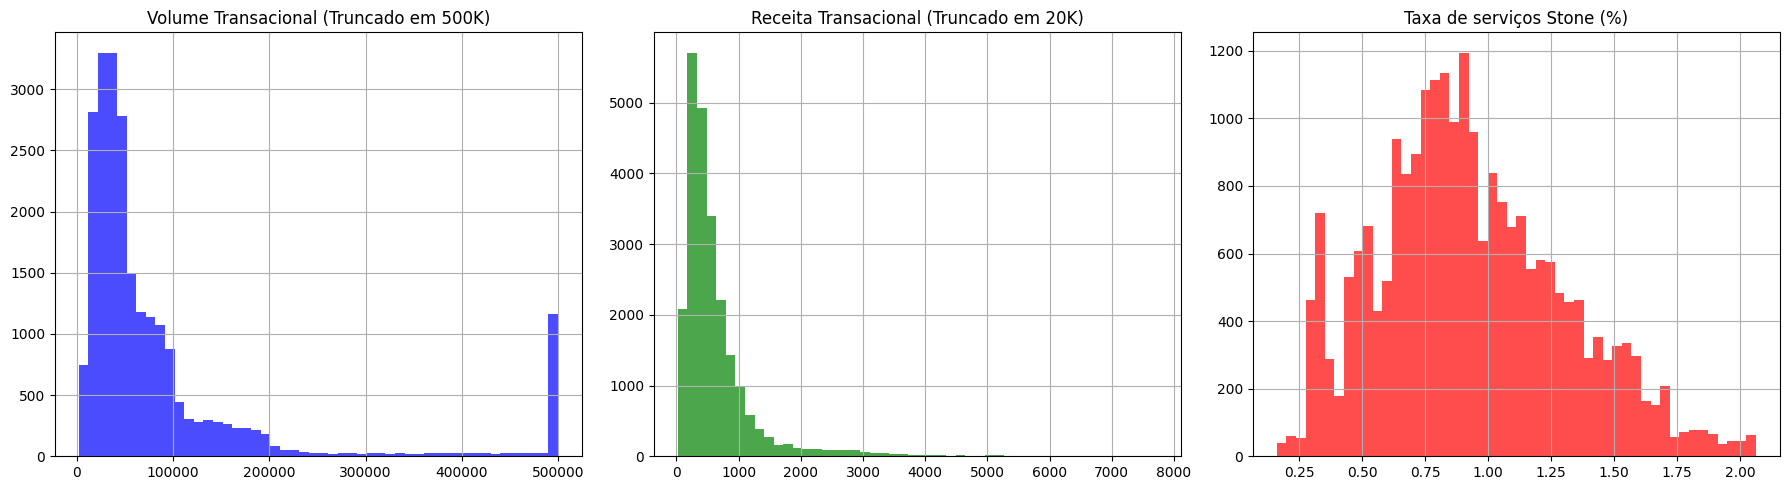

In [123]:
print("Estatísticas descritivas")
display(df_full.describe())

print("\nHistogramas truncados")
df_full_hist = df_full.copy()

# Limitar valores para melhor vizualização
df_full_hist["volume_transacional"] = df_full_hist["volume_transacional"].clip(
    upper=500000
)
df_full_hist["receita_transacional"] = df_full_hist["receita_transacional"].clip(
    upper=20000
)

# CCriar histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_full_hist["volume_transacional"].hist(ax=axes[0], bins=50, color="blue", alpha=0.7)
axes[0].set_title("Volume Transacional (Truncado em 500K)")

df_full_hist["receita_transacional"].hist(ax=axes[1], bins=50, color="green", alpha=0.7)
axes[1].set_title("Receita Transacional (Truncado em 20K)")

df_full_hist["taxa_stone"].hist(ax=axes[2], bins=50, color="red", alpha=0.7)
axes[2].set_title("Taxa de serviços Stone (%)")

plt.tight_layout()
plt.show()

#### Exercício clusterização KMeans: 

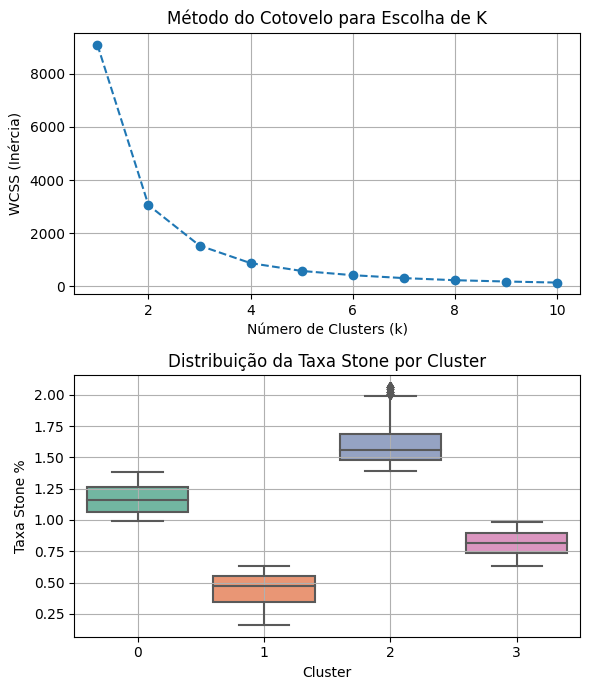

In [163]:
# Step 1: Aggregate taxa_stone per client (ID)
df_clients = df_full.groupby("ID", as_index=False)["taxa_stone"].mean()

# Step 2: Handle missing values (if any)
df_clients.dropna(subset=["taxa_stone"], inplace=True)

# Step 3: Standardize taxa_stone
scaler = StandardScaler()
df_clients["taxa_stone_scaled"] = scaler.fit_transform(df_clients[["taxa_stone"]])

# Step 4: Determine Optimal Clusters (Elbow Method)
wcss = []  # Within-Cluster Sum of Squares
k_range = range(1, 11)  # Testing k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_clients[["taxa_stone_scaled"]])
    wcss.append(kmeans.inertia_)  # Append WCSS (inertia)

# Step 5: Choose the best k (manually based on the elbow point)
optimal_k = 4  # Set manually based on the elbow curve

# Step 6: Apply K-Means with the chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clients["Cluster"] = kmeans.fit_predict(df_clients[["taxa_stone_scaled"]])

# Step 7: Merge cluster labels back to df_full
df_full = df_full.merge(df_clients[["ID", "Cluster"]], on="ID", how="left")

# 🔹 **Create Subplots (One Under the Other)**
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))

# 🔹 **Top Plot: Elbow Method**
axes[0].plot(k_range, wcss, marker="o", linestyle="--")
axes[0].set_xlabel("Número de Clusters (k)")
axes[0].set_ylabel("WCSS (Inércia)")
axes[0].set_title("Método do Cotovelo para Escolha de K")
axes[0].grid(True)

# 🔹 **Bottom Plot: Cluster Boxplot**
sns.boxplot(
    x=df_clients["Cluster"], y=df_clients["taxa_stone"], palette="Set2", ax=axes[1]
)
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Taxa Stone %")
axes[1].set_title("Distribuição da Taxa Stone por Cluster")
axes[1].grid(True)

# 🔹 **Adjust Layout for Better Spacing**
plt.tight_layout()
plt.show()

### Questão 2. Estando em um cenário de concorrência acirrada:


   * a. Qual estratégia comercial poderíamos implementar para diminuir nossa perda de clientes?
     * Resposta:
     * Diante do baixo payback  (apenas 11% da base cobriu o payback do CAC) e o baixo retorno da taxa_stone, **sugiro reduzir as taxas de manuten;áo fixas**, especialmete para clientes dos tiers 0 e 3. 
       * Baixo impacto nas receitas;
       * Consumidor tem visáo míope o que faz ele ponderar mais as taxas fixas do que as de algum outro serviço;
       * Você reduz  custo fixo do cliente;
       * Impacto mais direto sobre o cliente mediano;
       * Cliente ganha a sensação de liberdade.
  
   * b. Quais clientes você priorizaria para blindá-los de um eventual ataque da concorrência e por quê? Não é necessário especificar os IDs dos clientes, apenas explique quais são as características dos clientes e quantos são.
     * Resposta:
     * Clientes dos clusters 1 e 3. Cerca de 50% dos clientes do Cluster 1 e 70% do Cluster 3, contratam serviços da Stone (recebíveis). Esses dois grupos respondem por cerca de 60% dos clinetes com dados transacionais. 

In [125]:
stats_tier = (
    df_full.groupby(["Cluster"], as_index=True, sort=True)
    .agg(
        {
            "taxa_stone": ["mean", "min", "max"],
            "taxa_recebiveis": ["mean", "sum"],  # Mean of taxa_recebiveis
            "ID": ["nunique"],  # Count of unique clients overall
        }
    )
    .round(2)
)

# Count unique clients where taxa_recebiveis is NOT null
stats_tier["#_clients_recebiveis"] = (
    df_full.loc[df_full["taxa_recebiveis"].notna()].groupby("Cluster")["ID"].nunique()
)

# Flatten multi-level column names
stats_tier.columns = ["_".join(col).strip() for col in stats_tier.columns.values]

# Rename columns for clarity
stats_tier.rename(
    columns={
        "taxa_stone_mean": "taxa_stone_avg",
        "taxa_stone_min": "taxa_stone_min",
        "taxa_stone_max": "taxa_stone_max",
        "taxa_recebiveis_mean": "taxa_recebiveis_avg",
        "taxa_recebiveis_sum": "total_recebiveis",
        "ID_nunique": "#_clients",
        "#_clients_recebiveis_": "#_clientes_recebiveis",
    },
    inplace=True,
)

# Display result
stats_tier

,taxa_stone_avg,taxa_stone_min,taxa_stone_max,taxa_recebiveis_avg,total_recebiveis,#_clients,#_clientes_recebiveis
Cluster,,,,,,,
0,1.17,0.99,1.38,2.74,5275.77,2477,731
1,0.46,0.16,0.63,1.75,4168.38,1872,897
2,1.60,1.39,2.06,3.15,100.94,1204,13
3,0.81,0.64,0.98,2.38,15336.54,3542,2449


### Questão 3. Qual sua sugestão para maximizar o lucro da companhia?
Dica: Caso sinta falta de alguma informação necessária para a conclusão do case utilizando sua
linha de raciocínio, estime-a e explicite o racional.

* Resposta:
  * Estratégiade maximização de lucro: Para não afastar clientes cobrando taxas fixas mais caras, a sugestão é aumentar a taxa média dos recebíveis, em especial para os grupos 1 e 3. 
    * Grupo 3: Veja que não tem uma taxa de manutenção tão elevada (0.81%), porém tem a segunda menor taxa de recebíveis, além de ser o grupo que mais cntrata esse tipo de serviço (70% dos clientes do grupo contrataram o serviço).